In [0]:
#!pip install keras==2.3.1  
#!pip uninstall opencv-python -y
#!pip install opencv-contrib-python==3.4.2.17 --force-reinstall
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import matplotlib.pyplot as plt
from numpy import asarray
from pathlib import Path
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten,BatchNormalization,Dense,Dropout
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D,MaxPooling2D,ZeroPadding2D
from keras.utils import np_utils,to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from keras.regularizers import l2
from sklearn.decomposition import PCA
from numpy import load
from numpy import savez_compressed
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import preprocessing
import seaborn as sn
from google.colab import drive
import random


In [34]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
directory = '/content/drive/My Drive/CMPE255/src/'

In [0]:
fer_data=pd.read_csv(directory+'Data/fer2013.csv',delimiter=',')

In [0]:
def load_data():
    images = []
    labels = []
    for index,row in fer_data.iterrows():
        pixels=np.asarray(list(row['pixels'].split(' ')),dtype=np.uint8)
        img=pixels.reshape((48,48))
        labels.append(row['emotion'])
        images.append(img)
    return (images,labels)

## Load the data from the CSV






In [38]:
%time images,labels = load_data()

CPU times: user 20.8 s, sys: 796 ms, total: 21.6 s
Wall time: 21.7 s


In [0]:
def plot_images(data,label):
  emotion = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happy', 4 :'Sad', 5 : 'Surprise', 6 : 'Neutral'}
  f, axarr = plt.subplots(2,2,constrained_layout=True)
  axarr[0,0].imshow(data[0])
  axarr[0,0].set_title(emotion[label[0]])
  axarr[0,1].imshow(data[1])
  axarr[0,1].set_title(emotion[label[1]])
  axarr[1,0].imshow(data[2])
  axarr[1,0].set_title(emotion[label[2]])
  axarr[1,1].imshow(data[3])
  axarr[1,1].set_title(emotion[label[3]])

## Visualise four randomly selected images from the dataset

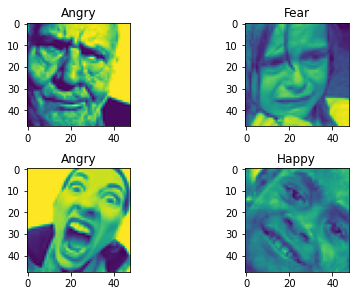

In [40]:
#randomly select 4 images
idx = np.random.choice(len(images),4,False)
plot_images([images[i] for i in idx] ,[labels[i] for i in idx])

In [0]:
num_clusters = 100
num_classes = 7
img_width = 48
img_height = 48

In [0]:
def extractSIFTDescriptors(image):
  sift = cv2.xfeatures2d.SIFT_create()
  kp, des = sift.detectAndCompute(image,None)
  return (kp,des)

def extractFeatures(images):
  #Stores all the descriptors found
  SIFTdesc = [] 
  #Each element corresponds to the descriptors found in an image
  img_desc = []
  for image in images:
    kp,des = extractSIFTDescriptors(image)
    if des is not None:
      SIFTdesc.extend(des)
      img_desc.append(des)
    else:
      img_desc.append([])
  return (SIFTdesc,img_desc)  

def constructHistogram(kmeans,image_descs,num_words):
  histograms = []
  for image_desc in image_descs:
      visual_words = []
      if len(image_desc):
        visual_words = kmeans.predict(image_desc)
      histograms.append(np.bincount(visual_words ,minlength=num_words))
  return np.array(histograms)

def constructVLAD(kmeans,image_descs,num_words):
  histograms = []
  code_book = kmeans.cluster_centers_
  for image_desc in image_descs:
      vlad = np.zeros((1,128))
      for key_point in image_desc:
        cluster_index = kmeans.predict(key_point.reshape(1,-1))
        vlad += code_book[cluster_index] - key_point
      histograms.extend(vlad)
  return np.array(preprocessing.normalize(histograms, norm='l2'))

In [43]:
%time SIFTdesc,image_desc = extractFeatures(images)

CPU times: user 2min 22s, sys: 10.1 s, total: 2min 32s
Wall time: 1min 17s


In [44]:
%time kmeans =   MiniBatchKMeans(init ='k-means++', n_clusters = num_clusters, batch_size = 64, verbose = 0).fit(SIFTdesc) 

CPU times: user 1min 33s, sys: 1min 2s, total: 2min 36s
Wall time: 1min 19s


In [45]:
%time X = constructHistogram(kmeans,image_desc,num_clusters)

CPU times: user 38.3 s, sys: 26.7 s, total: 1min 4s
Wall time: 32.9 s


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,labels,stratify=labels, test_size=0.2, random_state=42)

In [47]:
print("Train Set : " ,len(y_train),"images")
print("Test Set : " ,len(y_test),"images")

Train Set :  28709 images
Test Set :  7178 images


In [0]:
algo = KNeighborsClassifier()

In [0]:
param_grid = {'n_neighbors': np.arange(1, 25)}

In [0]:
knn_gscv = GridSearchCV(algo, param_grid, cv=5)

## Train the model on train data

In [54]:
%time knn_gscv.fit(X_train, y_train)

CPU times: user 1h 5min 42s, sys: 855 ms, total: 1h 5min 43s
Wall time: 1h 5min 45s


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [55]:
knn_gscv.best_params_

{'n_neighbors': 1}

In [0]:
algo = KNeighborsClassifier(n_neighbors = 1)

In [57]:
%time algo.fit(X_train, y_train)

CPU times: user 1.61 s, sys: 3.9 ms, total: 1.61 s
Wall time: 1.62 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

## Evaluate the model

In [58]:
algo.score(X_test,y_test)

0.32850376149345223

## Plot the confusion matrix

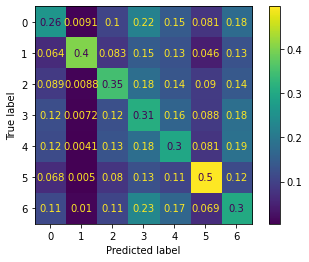

In [59]:
plot_confusion_matrix(algo,X_test,y_test,normalize='true')